In [1]:
%pylab inline
from utils import *
from ipdb import set_trace
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
# from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
# from ATLAS_dataset import *
from Model_alphaWGAN import *
# from Model_VAEGAN import Encoder
from utils import sinkhorn_pointcloud as sp

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
TEST_BATCH_SIZE=8
gpu = True
workers = 4

LAMBDA= 10
_eps = 1e-15
Use_ADNI = True
Use_BRATS = False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 3
gpu_1 = 3
torch_seed = 0
r_g = torch.manual_seed(torch_seed)
checkpoint_pth = 'adni_cce_checkpoint_4/'

In [3]:
if Use_ADNI:
    trainset = ADNIdataset(augmentation=True, img_size=64)
    # trainset, testset = data.random_split(dataset, [5, 5], generator=r_g)
    train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                              shuffle=True,num_workers=workers)
    # test_loader = torch.utils.data.DataLoader(testset,batch_size=TEST_BATCH_SIZE,
    #                                           shuffle=True,num_workers=workers)
if Use_BRATS:
    #'flair' or 't2' or 't1ce'
    trainset = BRATSdataset(imgtype='flair')
    train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
                                               num_workers=workers)
if Use_ATLAS:
    trainset = ATLASdataset(augmentation=True)
    train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)

In [4]:
G = Generator(noise = latent_dim)
D = Discriminator(is_dis=True)
# E = Encoder(gpu_ind=gpu_0)
E = Discriminator(out_class = latent_dim,is_dis=False, img_size=128)

G.cuda(gpu_0)
D.cuda(gpu_0)
E.cuda(gpu_1)

Discriminator(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv3d(512, 1000, kernel_size=(4, 4, 4), stride=(1, 1, 1))
)

In [5]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0006)
e_optimizer = optim.Adam(E.parameters(), lr=0.0002)

# Training

In [6]:
# torch.autograd.set_detect_anomaly(True)
#remove Variable usage
# real_y = torch.ones((BATCH_SIZE, 1)).cuda()#async=True))
# fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()#async=True))

# criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [7]:
# load the highest savepoints of all models
df = load_loss(path=checkpoint_pth)
iteration = load_checkpoint(G, D, E, None, '_iter', path=checkpoint_pth)

In [8]:
g_iter = 1
d_iter = 3
TOTAL_ITER = 100000
gen_load = inf_train_gen(train_loader)

lossStr [40000/100000]
        D: -29.1   
        En_Ge: 6.21e+02


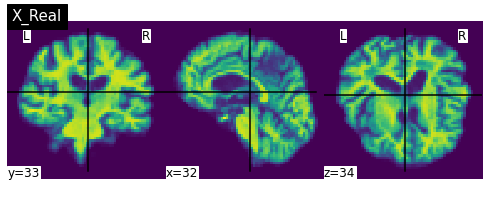

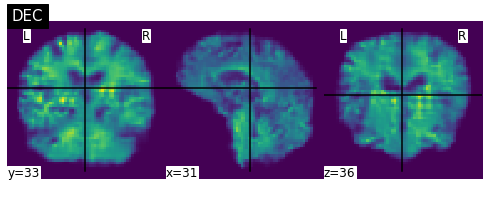

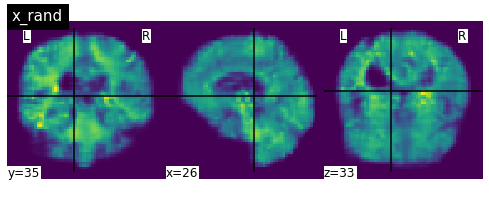

is_tsne: False, is_pca: True
index: 40000, sample_mean (blue): -0.0007456677849404514 sample_var:        0.9148463010787964, real_mean (yellow): 0.0006075920537114143 real_var: 1.0014455318450928


<Figure size 432x288 with 0 Axes>

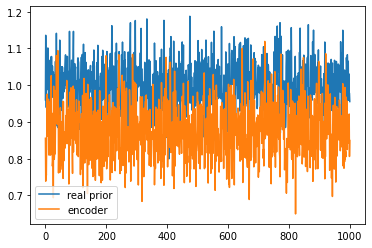

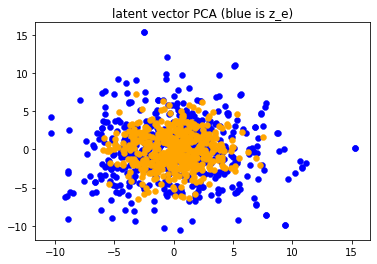

is_tsne: False, is_pca: True
index: 40000, sample_mean (blue): -0.8709810376167297 sample_var:        0.044650860130786896, real_mean (yellow): -0.8589001893997192 real_var: 0.056395478546619415


<Figure size 432x288 with 0 Axes>

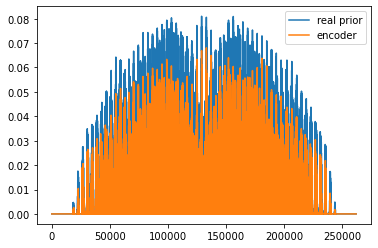

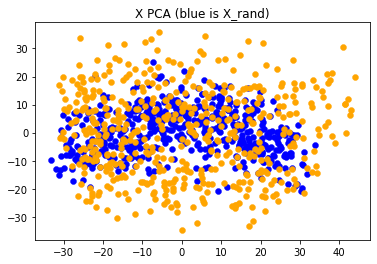

4000140002400034000440005400064000740008400094001040011400124001340014400154001640017400184001940020400214002240023400244002540077400784007940080400814008240083400844008540086400874008840089400904009140092400934009440095400964009740098400994010040101401024010340104401054010640107401084010940110401114011240113401144011540116401174011840119401204012140122401234012440125401264012740128401294013040131401324013340134401354013640137401384013940140401414014240143401444014540146401474014840149401504015140152401534015440155401564015740158401594016040161401624016340164401654016640167401684016940170401714017240173401744017540176401774017840179401804018140182401834018440185401864018740188401894019040191401924019340194401954019640197401984019940200402014020240203402044020540206402074020840209402104021140212402134021440215402164021740218402194022040221402224022340224402254022640227402284022940230402314023240233402344023540236402374023840239402404024140242402434024440245402464024740248402494025040251

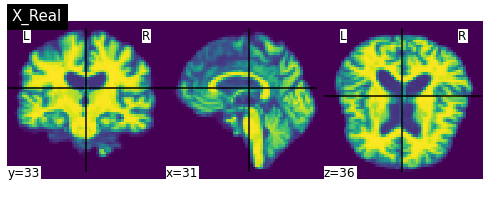

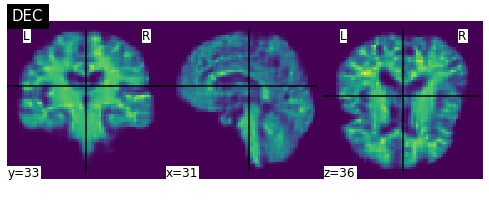

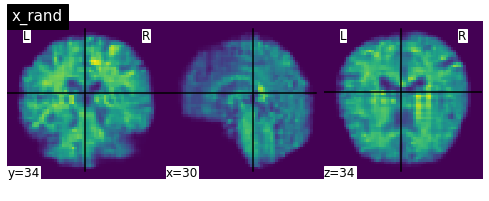

4100141002410034100441005410064100741008410094101041011410124101341014410154101641017410184101941020410214102241023410244102541026410274102841029410304103141032410334103441035410364103741038410394104041041410424104341044410454104641047410484104941050410514105241053410544105541056410574105841059410604106141062410634106441065410664106741068410694107041071410724107341074410754107641077410784107941080410814108241083410844108541086410874108841089410904109141092410934109441095410964109741098410994110041101411024110341104411054110641107411084110941110411114111241113411144111541116411174111841119411204112141122411234112441125411264112741128411294113041131411324113341134411354113641137411384113941140411414114241143411444114541146411474114841149411504115141152411534115441155411564115741158411594116041161411624116341164411654116641167411684116941170411714117241173411744117541176411774117841179411804118141182411834118441185411864118741188411894119041191411924119341194411954119641197411984119941200

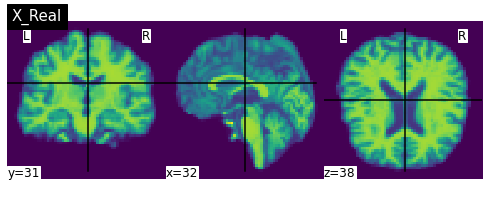

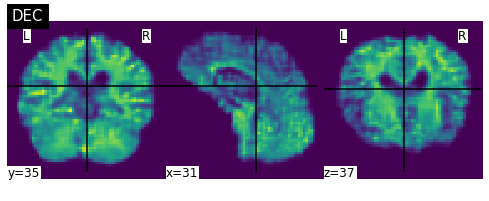

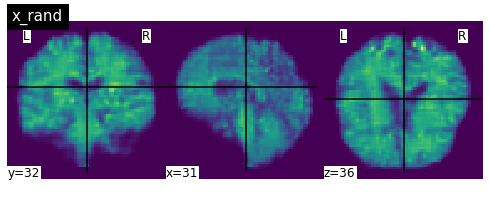

4200142002420034200442005420064200742008420094201042011420124201342014420154201642017420184201942020420214202242023420244202542026420274202842029420304203142032420334203442035420364203742038420394204042041420424204342044420454204642047420484204942050420514205242053420544205542056420574205842059420604206142062420634206442065420664206742068420694207042071420724207342074420754207642077420784207942080420814208242083420844208542086420874208842089420904209142092420934209442095420964209742098420994210042101421024210342104421054210642107421084210942110421114211242113421144211542116421174211842119421204212142122421234212442125421264212742128421294213042131421324213342134421354213642137421384213942140421414214242143421444214542146421474214842149421504215142152421534215442155421564215742158421594216042161421624216342164421654216642167421684216942170421714217242173421744217542176421774217842179421804218142182421834218442185421864218742188421894219042191421924219342194421954219642197421984219942200

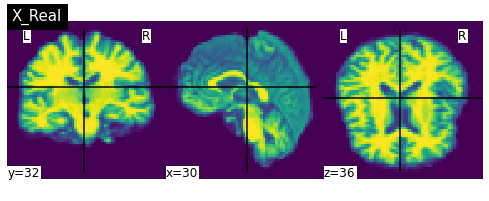

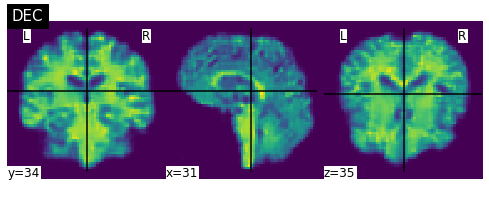

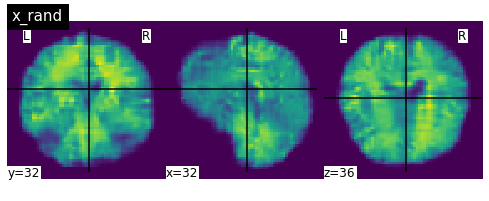

4300143002430034300443005430064300743008430094301043011430124301343014430154301643017430184301943020430214302243023430244302543026430274302843029430304303143032430334303443035430364303743038430394304043041430424304343044430454304643047430484304943050430514305243053430544305543056430574305843059430604306143062430634306443065430664306743068430694307043071430724307343074430754307643077430784307943080430814308243083430844308543086430874308843089430904309143092430934309443095430964309743098430994310043101431024310343104431054310643107431084310943110431114311243113431144311543116431174311843119431204312143122431234312443125431264312743128431294313043131431324313343134431354313643138431394314043141431424314343144431454314643147431484314943150431514315243153431544315543156431574315843159431604316143162431634316443165431664316743168431694317043171431724317343174431754317643177431784317943180431814318243183431844318543186431874318843189431904319143192431934319443195431964319743198431994320043201

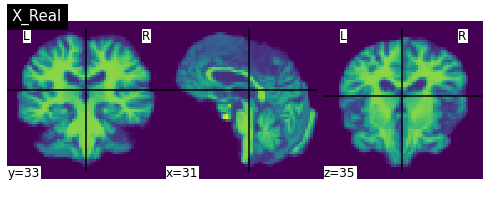

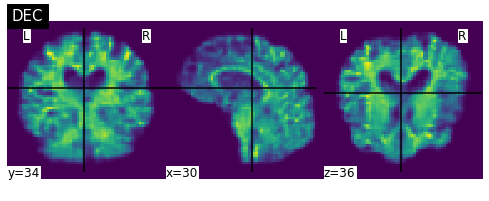

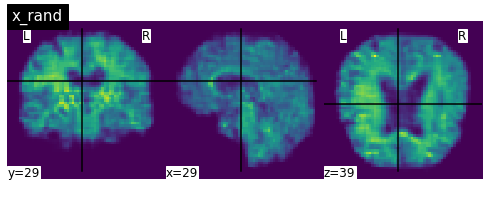

4400144002440034400444005440064400744008440094401044011440124401344014440154401644017440184401944020440214402244023440244402544026440274402844029440304403144032440334403444035440364403744038440394404044041440424404344044440454404644047440484404944050440514405244053440544405544056440574405844059440604406144062440634406444065440664406744068440694407044071440724407344074440754407644077440784407944080440814408244083440844408544086440874408844089440904409144092440934409444095440964409744098440994410044101441024410344104441054410644107441084410944110441114411244113441144411544116441174411844119441204412144122441234412444125441264412744128441294413044131441324413344134441354413644137441384413944140441414414244143441444414544146441474414844149441504415144152441534415444155441564415744158441594416044161441624416344164441654416644167441684416944170441714417244173441744417544176441774417844179441804418144182441834418444185441864418744188441894419044191441924419344194441954419644197441984419944200

In [ ]:
while iteration <= TOTAL_ITER:
    for p in D.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters():  
        p.requires_grad = True
        
    ######i#########################################
    # Train Generator 
    ###############################################
    for iters in range(g_iter):
        real_images = gen_load.__next__().cuda(gpu_0)
        _batch_size = real_images.size(0)
        if not _batch_size == BATCH_SIZE: 
            break
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        
        d_recon_loss = D(x_hat).mean()
        d_fake_loss = D(x_rand).mean()
        l1_loss = 100 * criterion_l1(x_hat.cuda(gpu_1),real_images)
        ### L2 loss(MSE loss) for reconstruction of the Encoder 
        z_ee, z_re = E(x_hat), E(x_rand)
        z_e_l2, z_r_l2 = 50 * criterion_mse(z_hat, z_ee), 50 * criterion_mse(z_rand, z_re)
        ###############################################
        loss1 = l1_loss - d_fake_loss - d_recon_loss + z_e_l2 + z_r_l2 
        
        G.zero_grad()
        E.zero_grad()
        if iters<g_iter-1:
            loss1.backward()
        else:
            loss1.backward(retain_graph=True)
        g_optimizer.step()
        
    ######i#########################################
    # Train Encoder
    ###############################################
    for p in D.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters(): 
        p.requires_grad = False
    for iters in range(g_iter):
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1)
        ### wasserstein loss between z_e and z_r ###################
        w_dist = 100 * sp.sinkhorn_loss(torch.transpose(z_rand, 0, 1), torch.transpose(z_hat, 0, 1), 0.1, 1000, 100, gpu=gpu_0)
        ###############################################
        
        e_loss = w_dist
        E.zero_grad()
        if iters<g_iter-1:
            e_loss.backward(retain_graph=True)
        else:
            e_loss.backward()
        e_optimizer.step()
        
        
    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False
        
    for iters in range(d_iter):
        d_optimizer.zero_grad()
        real_images = gen_load.__next__().cuda(gpu_0)
        _batch_size = real_images.size(0)
        
        if not _batch_size == BATCH_SIZE: 
            break
            
        x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
        gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand, cuda_ind=gpu_1)
        gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat, cuda_ind=gpu_1)
        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
        if iters < d_iter - 1:
            loss2.backward(retain_graph=True)
        else:
            loss2.backward()
        d_optimizer.step()
        
    ###############################################
    # Visualization
    ###############################################

    if iteration % 1000 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(loss2.item()) + '\n\
        En_Ge: {:<8.3}'.format(loss1.item())
        
        print('lossStr', lossStr)
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).detach().cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        
        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        
    ###############################################
    # Save the losses
    ###############################################
    loss_dict = {
        'index': [iteration],
        'l1_loss': [l1_loss.item()],
        'd_recon': [d_recon_loss.item()],
        'd_fake': [d_fake_loss.item()],
        'd_real': [-2*D(real_images).mean().item()],
        'gp_r': [gradient_penalty_r.item() if gradient_penalty_r else 0],
        'gp_h': [gradient_penalty_h.item() if gradient_penalty_h else 0],
        'loss1': [loss1.item()],
        'loss2': [loss2.item()],
        'z_e_l2': [z_e_l2.item()],
        'z_r_l2': [z_r_l2.item()],
        'w_dist': [w_dist.item()],
    }
    df = add_loss(df, loss_dict)
        

    ###############################################
    # Model Save
    ###############################################
    if iteration % 5000 == 0 and iteration:
        torch.save(G.state_dict(),f'./{checkpoint_pth}/G_iter'+str(iteration)+'.pth')
        torch.save(D.state_dict(),f'./{checkpoint_pth}/D_iter'+str(iteration)+'.pth')
        torch.save(E.state_dict(),f'./{checkpoint_pth}/E_iter'+str(iteration)+'.pth')
        write_loss(df, path=checkpoint_pth)
        viz_pca_tsne([E], trainset, is_tsne=False, is_pca=True, latent_size=latent_dim, index=iteration, is_cd=True, gpu_ind=gpu_1, batch_size=1)
        viz_pca_tsne([G], trainset, is_tsne=False, is_pca=True, latent_size=latent_dim, index=iteration, gpu_ind=gpu_1, batch_size=1)
#         calc_mmd(train_loader, G, iteration, count=1, gpu_ind=gpu_0, mode='linear', path=checkpoint_pth, no_write=False)
    iteration += 1
    print(iteration, end='')
   
    

In [ ]:
%debug

In [ ]:
loss_df = df
print(loss_df.columns)
loss_df[['loss1', 'loss2', 'loss3']].plot() 
loss_df[['l1_loss']].plot()
loss_df[['z_e_l2','z_r_l2','w_dist']].plot()
loss_df[['gp_r','gp_h']].plot()
loss_df[['loss2']].plot()
plt.figure(figsize=(400, 400))